# Part 2: Finetuning
From the evaluation scripts, we now know that GPT-Neo 125M is the best one for our purpose. Next we will try to finetune it to create a better model.

In [1]:
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer
from peft import LoraConfig, get_peft_model, TaskType, PeftModel
from datasets import Dataset
import torch
import nltk
import random
device = "cuda"

import dataset_utils
import model_utils
from datasets import load_dataset
import time
from datetime import timedelta

# Loading the model, tokenizer and dataset


In [2]:
df = dataset_utils.build_academic_dataset(tokenizer=None, limit_each=300)
contexts = df['context']
print(df.head())

Loading datasets...
Loading ASAP Essays
Total raw documents loaded: 300
Generating (context, continuation) pairs...
Generated 299 training pairs.
                                             context  \
0  A long time ago when I was in third grade I ha...   
1  Softball has to be one of the single most grea...   
2  Some people like making people laugh, I love i...   
3  "LAUGHTER" @CAPS1 I hang out with my friends, ...   
4  Well ima tell a story about the time i got @CA...   

                                        continuation  
0  The next day @PERSON2 and I were eating lunch ...  
1  Many of these girls were like sisters to me th...  
2  For example one time I hit myself in the head ...  
3  @CAPS1 I say trash can I really mean trash can...  
4  Then she said stupid @CAPS2 on the bus and com...  


In [3]:
model_name = "EleutherAI/gpt-neo-125M"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

model.to(device)

GPTNeoForCausalLM(
  (transformer): GPTNeoModel(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(2048, 768)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPTNeoBlock(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPTNeoAttention(
          (attention): GPTNeoSelfAttention(
            (attn_dropout): Dropout(p=0.0, inplace=False)
            (resid_dropout): Dropout(p=0.0, inplace=False)
            (k_proj): Linear(in_features=768, out_features=768, bias=False)
            (v_proj): Linear(in_features=768, out_features=768, bias=False)
            (q_proj): Linear(in_features=768, out_features=768, bias=False)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPTNeoMLP(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (c_proj): Linear(in_fe

In [4]:
def build_dataset_for_causal(pairs, tokenizer, max_length=512):
    """
    Build token-level dataset for causal LM fine-tuning.

    pairs: dict with keys "context", "continuation"
    tokenizer: HuggingFace tokenizer
    max_length: max token length

    Returns: dict suitable for Dataset.from_dict()
    """
    # Add pad token if missing
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    # Ensure EOS token exists
    eos = tokenizer.eos_token if tokenizer.eos_token else "</s>"

    # Merge context + continuation
    texts = [
        context.strip() + eos + " " + continuation.strip()
        for context, continuation in zip(pairs["context"], pairs["continuation"])
    ]

    # Tokenize
    encodings = tokenizer(
        texts,
        truncation=True,
        padding="longest",
        max_length=max_length,
        return_tensors=None,
    )

    # For causal LM, labels = input_ids (shifted inside model)
    encodings["labels"] = encodings["input_ids"].copy()

    return encodings

tokenized_pairs = build_dataset_for_causal(df, tokenizer, max_length=512)
dataset = Dataset.from_dict(tokenized_pairs)

# Train / Validation split
dataset = dataset.train_test_split(test_size=0.1)
train_ds = dataset["train"]
val_ds = dataset["test"]

# --------------------------------------------------------
# 4. Configure LoRA
# --------------------------------------------------------
lora_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    target_modules=["q_proj", "k_proj", "v_proj"],  # Updated for OPT models
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()


trainable params: 884,736 || all params: 126,083,328 || trainable%: 0.7017


In [10]:
args = TrainingArguments(
    output_dir="./lora_academic_model",
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=8,
    eval_strategy="steps", # Changed from evaluation_strategy to eval_strategy
    logging_steps=20,
    eval_steps=100,
    save_steps=200,
    num_train_epochs=20,
    warmup_steps=50,
    learning_rate=2e-4,
    fp16=True,
    report_to="none",
)

def data_collator(features):
    # `features` is a list of dictionaries, where each dictionary is one example from the dataset.
    # We need to extract the 'input_ids', 'attention_mask', and 'labels' from each example
    # and then stack them into tensors for the batch.
    return {
        "input_ids": torch.tensor([f["input_ids"] for f in features], dtype=torch.long),
        "attention_mask": torch.tensor([f["attention_mask"] for f in features], dtype=torch.long),
        "labels": torch.tensor([f["labels"] for f in features], dtype=torch.long),
    }

In [11]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer, # Pass the tokenizer to the Trainer for saving
    data_collator=data_collator, # Pass the data_collator
)

trainer.train()

C:\Users\tranh\AppData\Local\Temp\ipykernel_37044\2967949319.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss
100,1.327500,1.447034
200,1.271600,1.402048
300,1.242200,1.390849


TrainOutput(global_step=340, training_loss=1.3040255490471335, metrics={'train_runtime': 310.7296, 'train_samples_per_second': 17.314, 'train_steps_per_second': 1.094, 'total_flos': 1419916534087680.0, 'train_loss': 1.3040255490471335, 'epoch': 20.0})

,loss,grad_norm,learning_rate,epoch,step,eval_loss,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
16,1.2422,0.138151,2.827586e-05,17.651852,300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,NaN,NaN,NaN,17.651852,300,1.390849,0.7521,39.89,19.945,NaN,NaN,NaN,NaN,NaN
18,1.2346,0.120548,1.448276e-05,18.829630,320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,1.2579,0.119515,6.896552e-07,20.000000,340,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,NaN,NaN,NaN,20.000000,340,NaN,NaN,NaN,NaN,310.7296,17.314,1.094,1.419917e+15,1.304026


<Figure size 1000x500 with 0 Axes>

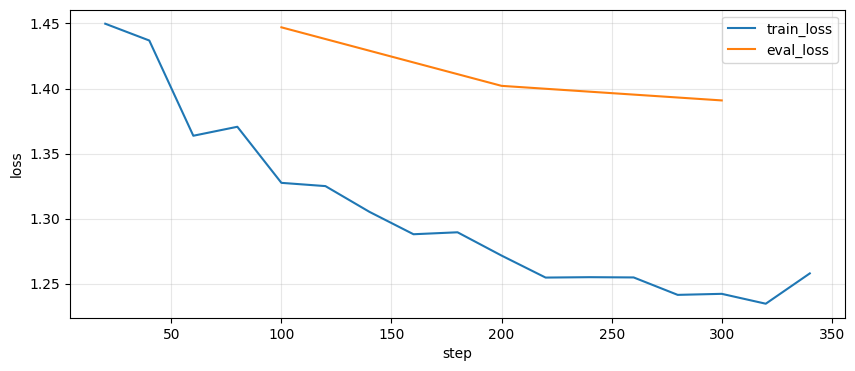

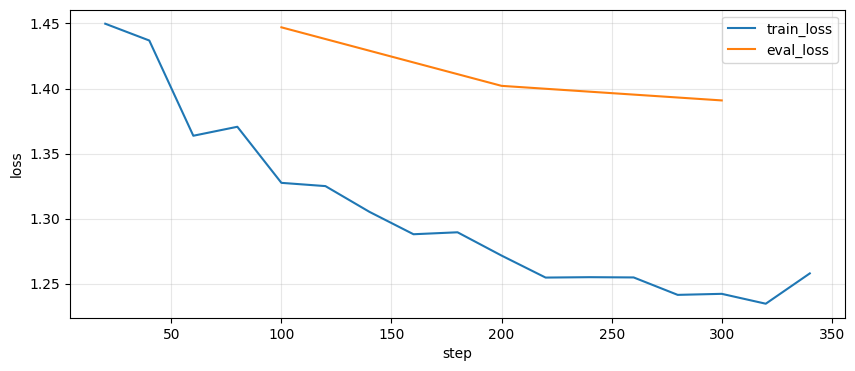

No loss columns found in log history to plot.


In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract Trainer logs
log_history = trainer.state.log_history
if len(log_history) == 0:
	print("No training logs captured. Ensure training completed without errors.")
else:
	df_log = pd.DataFrame(log_history)
	display(df_log.tail())

	# Plot training/eval loss over steps
	plt.figure(figsize=(10, 5))
	plotted = False
	for col, label in [("loss", "train_loss"), ("eval_loss", "eval_loss")]:
		train_rows = df_log[df_log['loss'].notna()]
		eval_rows = df_log[df_log['eval_loss'].notna()]

		plt.figure(figsize=(10,4))
		plt.plot(train_rows['step'], train_rows['loss'], label='train_loss')
		plt.plot(eval_rows['step'], eval_rows['eval_loss'], label='eval_loss')
		plt.xlabel('step'); plt.ylabel('loss'); plt.legend(); plt.grid(True, alpha=0.3)
		plt.show()
	if plotted:
		plt.xlabel("Step")
		plt.ylabel("Loss")
		plt.title("Training/Eval Loss over Steps")
		plt.legend()
		plt.grid(True, alpha=0.3)
		plt.show()
	else:
		print("No loss columns found in log history to plot.")

In [ ]:
# Save LoRA weights
trainer.save_model("./lora_academic_model")
model.save_pretrained("./lora_academic_model")
tokenizer.save_pretrained("./lora_academic_model")

('./lora_academic_model\\tokenizer_config.json',
 './lora_academic_model\\special_tokens_map.json',
 './lora_academic_model\\vocab.json',
 './lora_academic_model\\merges.txt',
 './lora_academic_model\\added_tokens.json',
 './lora_academic_model\\tokenizer.json')

# Loading the model

Testing loading the model to see if it works as intended

In [13]:
model_path = "./lora_academic_model"

# 1 Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_path)

# GPT2 requires pad token
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

device = "cuda"
# 2 Load base model (must match the one you fine-tuned)
# Use the same model_name selected for fine-tuning
model_name = "EleutherAI/gpt-neo-125M"
print(f"Loading model on device: {device}")
model = AutoModelForCausalLM.from_pretrained(
    model_name, 
    torch_dtype=torch.float16 if device == 'cuda' else torch.float32
).to(device)

# 3┒┓ Load LoRA adapters
model = PeftModel.from_pretrained(model, model_path)

model.to(device)
print(f"Model loaded on: {next(model.parameters()).device}")

model.eval()

Loading model on device: cuda


`torch_dtype` is deprecated! Use `dtype` instead!


Model loaded on: cuda:0


PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): GPTNeoForCausalLM(
      (transformer): GPTNeoModel(
        (wte): Embedding(50257, 768)
        (wpe): Embedding(2048, 768)
        (drop): Dropout(p=0.0, inplace=False)
        (h): ModuleList(
          (0-11): 12 x GPTNeoBlock(
            (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (attn): GPTNeoAttention(
              (attention): GPTNeoSelfAttention(
                (attn_dropout): Dropout(p=0.0, inplace=False)
                (resid_dropout): Dropout(p=0.0, inplace=False)
                (k_proj): lora.Linear(
                  (base_layer): Linear(in_features=768, out_features=768, bias=False)
                  (lora_dropout): ModuleDict(
                    (default): Dropout(p=0.05, inplace=False)
                  )
                  (lora_A): ModuleDict(
                    (default): Linear(in_features=768, out_features=16, bias=False)
                  )
                  (lora_

# Modified architecture: Re-ranking head.
Train a lightweight MLP scoring head on pooled LM representations. At inference, generate N candidates and re-rank using this head for better top-1 precision.

### 1: Creating a dataset with ML ArXiv Paper Dataset

In [21]:
nltk.download('punkt_tab')
nltk.download("punkt")

contexts = []
positives = []

NSPds = load_dataset("CShorten/ML-ArXiv-Papers")

for row in NSPds["train"]:
    sentences = nltk.sent_tokenize(row["abstract"])
    for i in range(len(sentences) - 1):
        contexts.append(sentences[i])
        positives.append(sentences[i+1])

# Build a global pool of sentences
sentence_pool = []
for row in NSPds["train"]:
    sentence_pool.extend(nltk.sent_tokenize(row["abstract"]))

def sample_negatives(k):
    return random.sample(sentence_pool, k)

nsp_data = {
    "context": [],
    "candidates": [],
    "labels": []
}

num_negatives = 3  # N candidates = 1 positive + 3 negatives
sample_size = 100 # Increased from 10 to ensure sufficient training data

# Ensure contexts and positives are of the same length
assert len(contexts) == len(positives), "Contexts and positives lists must have the same length."

# Generate random indices for sampling
# Use min(sample_size, len(contexts)) to avoid errors if contexts has less than 2000 items
random_indices = random.sample(range(len(contexts)), min(sample_size, len(contexts)))

for i in random_indices:
    ctx = contexts[i]
    pos = positives[i]
    negs = sample_negatives(num_negatives)

    nsp_data["context"].append(ctx)
    nsp_data["candidates"].append([pos] + negs)
    nsp_data["labels"].append([1] + [0]*num_negatives)
    
rerank_ds = Dataset.from_dict(nsp_data)
rerank_ds


[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\tranh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tranh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Dataset({
    features: ['context', 'candidates', 'labels'],
    num_rows: 100
})

## 2. Reranker Model and Dataset

In [22]:
import torch
import torch.nn as nn

class RerankerModel(nn.Module):
    def __init__(self, lm, tokenizer, hidden_dim=768):
        super().__init__()
        self.lm = lm
        self.tokenizer = tokenizer

        # Ensure LM returns hidden states
        self.lm.config.output_hidden_states = True
        self.lm.config.return_dict = True

        # MLP scoring head (FP32)
        self.scorer = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.lm(
            input_ids=input_ids,
            attention_mask=attention_mask,
            output_hidden_states=True,
            return_dict=True
        )

        hidden_states = outputs.hidden_states[-1]  # (B, T, H) in FP16

        # find EOS
        eos_mask = (input_ids == self.tokenizer.eos_token_id)
        idx = eos_mask.float().argmax(dim=1)

        # gather
        batch_idx = torch.arange(hidden_states.size(0), device=hidden_states.device)
        eos_hidden = hidden_states[batch_idx, idx]

        # convert to float32 before MLP
        eos_hidden = eos_hidden.float()

        # scalar score
        score = self.scorer(eos_hidden)  # (B, 1)
        return score.squeeze(-1)



In [23]:
import torch
from torch.utils.data import Dataset, DataLoader

class RerankDataset(Dataset):
    def __init__(self, hf_dataset, tokenizer, max_len=256):
        self.dataset = hf_dataset
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        context = item["context"]
        candidates = item["candidates"]
        labels = item["labels"]

        input_ids_list = []
        attn_list = []

        for cand in candidates:
            text = context + self.tokenizer.eos_token + " " + cand
            enc = self.tokenizer(
                text,
                padding="max_length",
                truncation=True,
                max_length=self.max_len,
                return_tensors="pt"
            )
            input_ids_list.append(enc["input_ids"])
            attn_list.append(enc["attention_mask"])

        input_ids = torch.cat(input_ids_list, dim=0)  # (num_candidates, seq_len)
        attention_mask = torch.cat(attn_list, dim=0)  # (num_candidates, seq_len)
        labels = torch.tensor(labels, dtype=torch.long)

        return input_ids.squeeze(1), attention_mask.squeeze(1), labels


In [ ]:
train_loader = DataLoader(
    RerankDataset(rerank_ds, tokenizer),
    batch_size=4,
    shuffle=True
)


print(f"Dataset size: {len(rerank_ds)}")
print(f"Number of batches per epoch: {len(train_loader)}")

Dataset size: 100
Number of batches per epoch: 25


## 3. Training loop for LoRA model

In [26]:
print(f"\nInitializing reranker on device: {device}")
if device == 'cuda':
    print(f"GPU Memory before model load: {torch.cuda.memory_allocated()/1e9:.2f} GB")

reranker = RerankerModel(model, tokenizer).to(device)

# FREEZE BASE PARAMETER
for param in reranker.lm.parameters():
    param.requires_grad = False

optimizer = torch.optim.AdamW(reranker.parameters(), lr=1e-4)

criterion = nn.CrossEntropyLoss()
model.config.return_dict = True
model.config.output_hidden_states = True

if device == 'cuda':

    print(f"GPU Memory after model load: {torch.cuda.memory_allocated()/1e9:.2f} GB")
    print(f"Reranker is on: {next(reranker.parameters()).device}")


Initializing reranker on device: cuda
GPU Memory before model load: 0.91 GB
GPU Memory after model load: 0.91 GB
Reranker is on: cuda:0


In [29]:
num_epochs = 100
start_time = time.perf_counter()

for epoch in range(num_epochs):
    epoch_start = time.perf_counter()
    print(f"\nStarting epoch {epoch + 1}/{num_epochs}")
    if device == 'cuda':
        print(f"GPU Memory at epoch start: {torch.cuda.memory_allocated()/1e9:.2f} GB")

    reranker.train()
    
    batch_count = 0
    for input_ids, attn_mask, labels in train_loader:
        batch_count += 1
        if batch_count == 1 and device == 'cuda':
            print(f"Processing first batch on GPU...")

        B, N, T = input_ids.shape
        input_ids = input_ids.to(device)
        attn_mask = attn_mask.to(device)
        labels = labels.to(device)

        flat_ids = input_ids.view(B*N, T)
        flat_att = attn_mask.view(B*N, T)

        scores = reranker(flat_ids, flat_att)
        scores = scores.view(B, N)

        loss = criterion(scores, labels.argmax(dim=1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Timing calculations
    epoch_time = time.perf_counter() - epoch_start
    elapsed = time.perf_counter() - start_time

    avg_epoch_time = elapsed / (epoch + 1)
    remaining_epochs = num_epochs - (epoch + 1)
    eta_seconds = remaining_epochs * avg_epoch_time
    eta = timedelta(seconds=int(eta_seconds))

    print(f"Epoch {epoch + 1}/{num_epochs} | Loss: {loss.item():.4f} | "

          f"Batches: {batch_count} | Epoch time: {epoch_time:.2f}s | "

          f"ETA: {eta}")


Starting epoch 1/100
GPU Memory at epoch start: 0.91 GB
Processing first batch on GPU...
Epoch 1/100 | Loss: 1.3861 | Batches: 25 | Epoch time: 3.57s | ETA: 0:05:53

Starting epoch 2/100
GPU Memory at epoch start: 0.91 GB
Processing first batch on GPU...
Epoch 2/100 | Loss: 1.3838 | Batches: 25 | Epoch time: 3.47s | ETA: 0:05:46

Starting epoch 3/100
GPU Memory at epoch start: 0.91 GB
Processing first batch on GPU...
Epoch 3/100 | Loss: 1.3858 | Batches: 25 | Epoch time: 3.47s | ETA: 0:05:41

Starting epoch 4/100
GPU Memory at epoch start: 0.91 GB
Processing first batch on GPU...
Epoch 4/100 | Loss: 1.3935 | Batches: 25 | Epoch time: 3.37s | ETA: 0:05:34

Starting epoch 5/100
GPU Memory at epoch start: 0.91 GB
Processing first batch on GPU...
Epoch 5/100 | Loss: 1.3848 | Batches: 25 | Epoch time: 3.41s | ETA: 0:05:30

Starting epoch 6/100
GPU Memory at epoch start: 0.91 GB
Processing first batch on GPU...
Epoch 6/100 | Loss: 1.4130 | Batches: 25 | Epoch time: 3.42s | ETA: 0:05:26

Sta

In [30]:
def rerank(model, context, candidates):
    inputs = []
    for c in candidates:
        txt = context + tokenizer.eos_token + " " + c
        enc = tokenizer(txt, return_tensors="pt").to("cuda")
        inputs.append(enc)

    input_ids = torch.cat([x["input_ids"] for x in inputs])
    attn = torch.cat([x["attention_mask"] for x in inputs])

    with torch.no_grad():
        scores = model(input_ids, attn)

    idx = torch.argmax(scores).item()
    return candidates[idx], scores


# @jason can u pls come in and check this part again